In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os

In [2]:
BASE_DIR = os.path.abspath("..")  # adjust if needed
DATASET_PATH = os.path.join(BASE_DIR, "data",  "fullset_train_cs.csv")
MODEL_PATH = os.path.join(BASE_DIR, "data", "trained_models", "rf_model.pkl")
FEATURE_SELECTOR_PATH = os.path.join(BASE_DIR, "data", "trained_models", "feature_selector.pkl")


In [3]:
df = pd.read_csv(DATASET_PATH)

print("Dataset Shape:", df.shape)
print("Columns:", df.columns[:10])  # show first 10 cols
# Label is the column '0.951'
y = df["0.951"].values

# Features = all other columns
X = df.drop(columns=["0.951"]).values

print("Dataset shape:", X.shape, "Labels:", np.bincount(y))



Dataset Shape: (2927, 957)
Columns: Index(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'], dtype='object')
Dataset shape: (2927, 956) Labels: [ 864 2063]


In [4]:
from sklearn.model_selection import train_test_split

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (2341, 956) Test shape: (586, 956)


In [5]:
import numpy as np

freq_threshold = 50  # threshold for frequency
malicious_freq = np.sum(X_train[y_train==1], axis=0)
benign_freq = np.sum(X_train[y_train==0], axis=0)

freq_features = np.where(
    (malicious_freq > freq_threshold) | (benign_freq > freq_threshold)
)[0]

print("Frequency-selected features:", len(freq_features))


Frequency-selected features: 541


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

def train_rf(features, label):
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(features, label)
    return rf

def evaluate(rf, X_test, y_test, name):
    y_pred = rf.predict(X_test)
    print(f"\n--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# (a) Frequency-only
rf_freq = train_rf(X_train[:, freq_features], y_train)
evaluate(rf_freq, X_test[:, freq_features], y_test, "Frequency-only")



--- Frequency-only ---
Accuracy: 0.9590443686006825
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       173
           1       0.97      0.97      0.97       413

    accuracy                           0.96       586
   macro avg       0.95      0.95      0.95       586
weighted avg       0.96      0.96      0.96       586



In [8]:
import joblib

# Save trained Random Forest model
joblib.dump(rf_freq, "random_forest_apk.pkl")


# Save only the selected features (important!)
joblib.dump(freq_features, "features.pkl")


print("✅ Model and feature indices saved successfully!")


✅ Model and feature indices saved successfully!


In [9]:
import pandas as pd

# Convert numpy arrays back into a DataFrame for saving
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test, columns=["label"])

# Save test set
X_test_df.to_csv("X_test.csv", index=False)
y_test_df.to_csv("y_test.csv", index=False)

print("✅ Test dataset saved")


✅ Test dataset saved


In [11]:
import joblib
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Load model and features
rf_model = joblib.load("random_forest_apk.pkl")
selected_features = joblib.load("features.pkl")  # indices

# Load test set
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")["label"]

# Select same features used during training
X_test_selected = X_test.iloc[:, selected_features]

# Predict
y_pred = rf_model.predict(X_test_selected)

# Evaluate
print("✅ Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Test Accuracy: 0.9590443686006825

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       173
           1       0.97      0.97      0.97       413

    accuracy                           0.96       586
   macro avg       0.95      0.95      0.95       586
weighted avg       0.96      0.96      0.96       586



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Confusion Matrix:
 [[161  12]
 [ 12 401]]


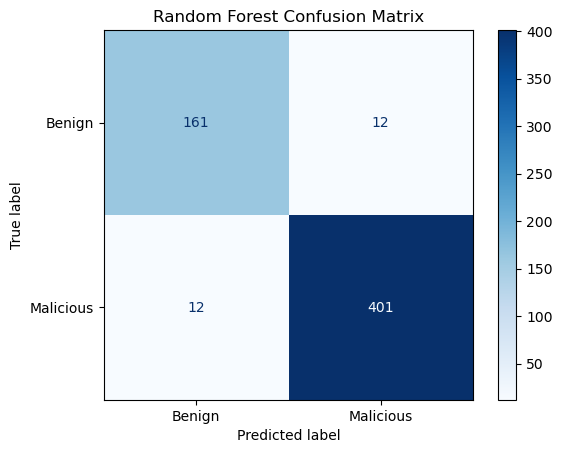

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Select features correctly depending on type
X_test_selected = X_test.iloc[:, freq_features]  # if DataFrame
# X_test_selected = X_test[:, freq_features]    # if NumPy array

# Predict
y_test_pred = rf_model.predict(X_test_selected)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malicious"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()


In [ ]:
import joblib
import os

# Make sure the directory exists
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

# Save Random Forest model
joblib.dump(rf_freq, MODEL_PATH)
print("Random Forest model saved at:", MODEL_PATH)


Random Forest model saved at: /Users/ganavimc/Desktop/Cyber Sheild/backend/data/trained_models/rf_model.pkl


In [ ]:
joblib.dump(freq_features, FEATURE_SELECTOR_PATH)
print("Selected features saved at:", FEATURE_SELECTOR_PATH)


Selected features saved at: /Users/ganavimc/Desktop/Cyber Sheild/backend/data/trained_models/feature_selector.pkl


In [ ]:
import pandas as pd
import joblib
import os

# -----------------------------
# 1️⃣ Provide full file paths directly
# -----------------------------
# Copy the full path from your system for the model and feature selector
MODEL_PATH = "/Users/ganavimc/Desktop/Cyber Sheild/backend/data/random_forest_apk.pkl"
FEATURE_SELECTOR_PATH = "/Users/ganavimc/Desktop/Cyber Sheild/backend/notebook/features.pkl"

# Load Random Forest model and selected feature indices
rf_model = joblib.load(MODEL_PATH)
selected_features = joblib.load(FEATURE_SELECTOR_PATH)

print("Model and feature selector loaded successfully.")

# -----------------------------
# 2️⃣ Define inference function
# -----------------------------
def predict_apks(X_new):
    """
    Predict if APKs are malicious or benign using the trained Random Forest model.

    Parameters:
        X_new (pd.DataFrame): DataFrame with the same features as training before selection.
    
    Returns:
        pd.DataFrame: Predictions with probabilities
    """
    # Ensure X_new is a DataFrame
    if not isinstance(X_new, pd.DataFrame):
        X_new = pd.DataFrame(X_new)
    
    # Select the same features as training
    X_selected = X_new.iloc[:, selected_features]
    
    # Predict class labels
    y_pred = rf_model.predict(X_selected)
    
    # Predict probabilities for class 1 (malicious)
    y_prob = rf_model.predict_proba(X_selected)[:, 1]
    
    # Prepare results DataFrame
    results_df = pd.DataFrame({
        "APK_ID": range(1, len(y_pred)+1),
        "Prediction": y_pred,
        "Probability": y_prob
    })
    
    # Map 0/1 to readable labels
    results_df["Prediction"] = results_df["Prediction"].map({0: "Benign", 1: "Malicious"})
    
    return results_df

# -----------------------------
# 3️⃣ Example usage
# -----------------------------
# X_new_df = pd.read_csv("/Users/yourusername/Desktop/your_project_folder/data/new_apk_features.csv")
# results = predict_apks(X_new_df)
# print(results.head())
# results.to_csv("/Users/yourusername/Desktop/your_project_folder/data/apk_predictions.csv", index=False)
# print("Predictions saved.")


Model and feature selector loaded successfully.
